### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [4]:
#二原子の軌跡からFを計算
function compute_free_energy(coords1_trj, coords2_trj, beta, epsilon, sigma)
    N = size(coords1_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in zip(coords1_trj, coords2_trj)]
    F = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* U_array)))
    return F
end
#deltaUからdeltaFの近似を計算
function compute_deltaF(coords_trj , beta, epsilon, sigma, U_target_array)
    N = size(coords_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in coords_trj]
    deltaU = U_target_array - U_array
    deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    return deltaF
end

compute_deltaF (generic function with 1 method)

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [5]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(coords_trj) = compute_deltaF(coords_trj, beta, m.P[1], m.P[2], U_target_array)

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-2)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        delta_U = compute_energy(next_coords1, next_coords2, epsilon, sigma) - compute_energy(coords1, coords2, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### 訓練データの作成

In [8]:
epsilon_true = 1.0
sigma_true = 2.0
epsilon_target = 1.2
sigma_target = 2.5

#kB = 1.380649e-23 #ボルツマン定数
kBT = 2.0
beta = 1.0/(kBT)

#seed_value = 123 #乱数固定
#Random.seed!(seed_value)

X_train = []
y_train = []
coords = ([0.0, 0.0, 0.0], [2.0, 0.0, 0.0]) #初期座標
coords_target = ([0.0, 0.0, 0.0], [2.5, 0.0, 0.0])
nstep = 100000

coords1_trj, coords2_trj, alpha = mcmc(coords[1], coords[2], epsilon_true, sigma_true, nstep, beta)
coords1_trj_target, coords2_trj_target, alpha = mcmc(coords_target[1], coords_target[2], epsilon_target, sigma_target, nstep, beta)

(Any[[0.0008447920291058068, 1.3372589369676813, -0.89154655295955], [0.0018498732185082245, -0.003965977035291136, -0.003517288072838517], [0.000946289158818534, -0.008038167169927724, 0.0014637407982196352], [-0.003333248826127594, -0.0076891083463835365, -0.003359566276631952], [-0.006787418248112587, -0.00538339854422454, -0.0004606588070988713], [-0.003313515600756709, -0.005319118398923363, -0.0020606843445502244], [-0.0038088593101753467, -0.00891474516936936, -0.00335039451896633], [-0.0016509135248124296, -0.007880299815031527, -0.008274076458102174], [-0.004365030640194511, -0.0033347140774647463, -0.0096537014945213], [-0.005353072115848616, 0.0009617272751483242, -0.004742730150939675]  …  [-0.00476996707213601, 1.338017711008993, -0.8758966594616107], [-0.0036108845248933215, 1.337685002724605, -0.8802777079800279], [0.0006539021981508582, 1.3371737654723155, -0.8765887003125646], [0.0003119016365284262, 1.3342829451049738, -0.8724688304751591], [0.002480928111053011, 1.33

In [9]:
#ポテンシャルエネルギーの配列
U_array = map(x -> compute_energy(x[1], x[2], epsilon_true, sigma_true), zip(coords1_trj, coords2_trj))
U_target_array = map(x -> compute_energy(x[1], x[2], epsilon_target, sigma_target), zip(coords1_trj_target, coords2_trj_target))

#FとF_targetを計算
F = compute_free_energy(coords1_trj, coords2_trj, beta, epsilon_true, sigma_true)
F_target = compute_free_energy(coords1_trj_target, coords2_trj_target, beta, epsilon_target, sigma_target)

#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = collect(zip(coords1_trj, coords2_trj))
y_train = F_target - F 

#epsilon_trueとsigma_trueを用いて自由エネルギーの差の近似を計算
deltaF = compute_deltaF(X_train, beta, epsilon_true, sigma_true, U_target_array)

-0.7090120117775891

In [10]:
println("F = $(F)")
println("F_target = $(F_target)")
println("(F_target - F) = $(F_target - F)")
println("deltaF = $(deltaF)")

F = -0.47674155581369004
F_target = -1.0078795151180386
(F_target - F) = -0.5311379593043486
deltaF = -0.7090120117775891


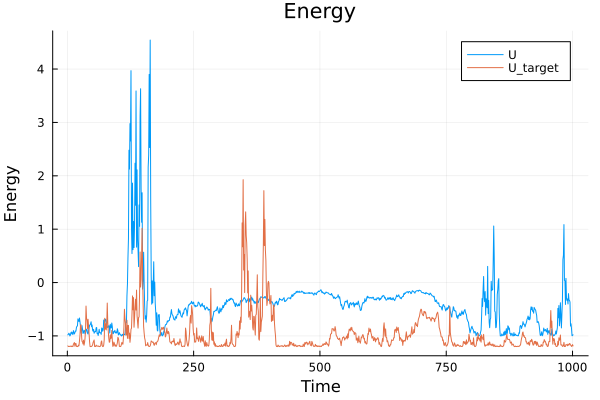

In [11]:
plot(U_array[1:100:end],title="Energy",
    xlabel="Time", ylabel="Energy",
    label="U")
plot!(U_target_array[1:100:end],title="Energy",
    xlabel="Time", ylabel="Energy",
    label="U_target")

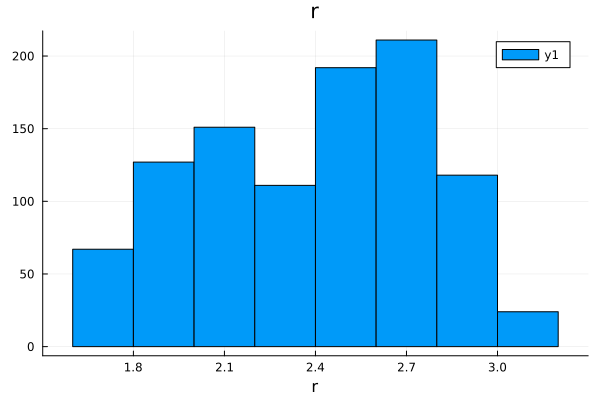

In [12]:
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(coords1_trj, coords2_trj)]
histogram(r[1:100:end],title="r",xlabel="r")

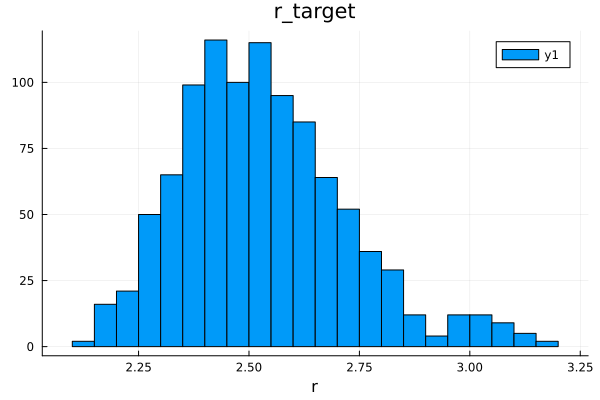

In [13]:
r_target = [sqrt(sum((x - y).^2)) for (x, y) in zip(coords1_trj_target, coords2_trj_target)]
histogram(r_target[1:100:end],title="r_target",xlabel="r")

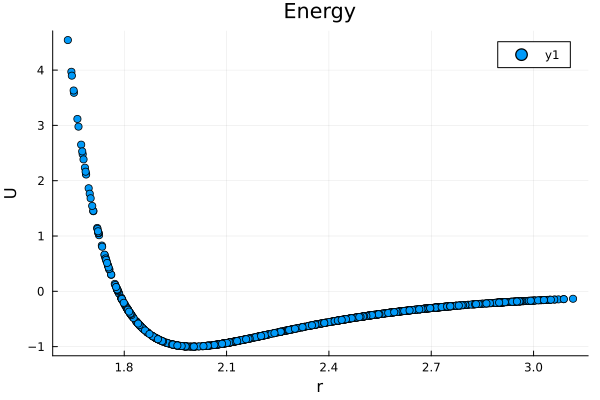

In [14]:
scatter(r[1:100:end], U_array[1:100:end],
        xlabel="r", ylabel="U", title="Energy")

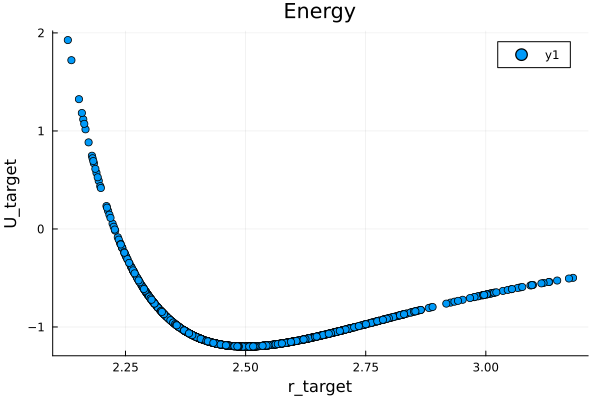

In [15]:
scatter(r_target[1:100:end], U_target_array[1:100:end],
        xlabel="r_target", ylabel="U_target", title="Energy")

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [16]:
# Lossの定義
m = Energy([0.8, 1.8])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

0.02338669637283114

In [17]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3)

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [18]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [19]:
# 訓練
loss_train = []

for epoch in 1:501
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    push!(loss_train, loss(X_train, y_train))
    if epoch%100 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

Epoch: 1, loss: 0.023101918678044828
param: [0.8009999999157579, 1.8009999999401438]
Epoch: 101, loss: 0.00656254811710595
param: [0.8915669556869054, 1.8791527522154536]
Epoch: 201, loss: 0.0024354238708018294
param: [0.9590811620383833, 1.900342492127183]
Epoch: 301, loss: 0.0008244020445258764
param: [1.0081687680356488, 1.901822203009472]
Epoch: 401, loss: 0.00023057981146863484
param: [1.040546847068232, 1.9014854472673655]
Epoch: 501, loss: 5.270528290075678e-5
param: [1.0595718672342818, 1.9011955099616507]


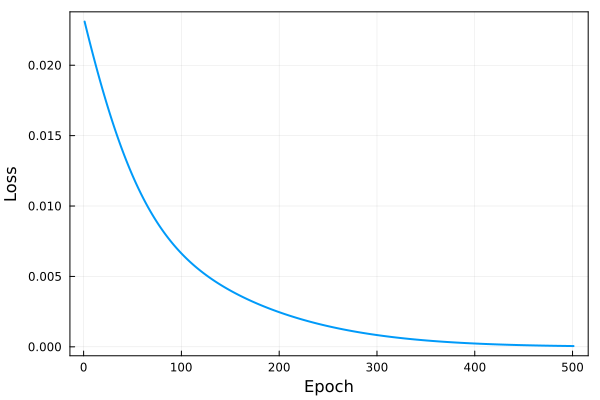

In [20]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [21]:
println("Ground-truth epsilon: ", epsilon_true)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_true)
println("Estimate sigma:     ", m.P[2])

Ground-truth epsilon: 1.0
Estimate epsilon:     1.0595718672342818
Ground-truth sigma: 2.0
Estimate sigma:     1.9011955099616507
